# Classification based on leaves features

### Importing our own functions


In [1]:
from src.Data import Data
from src.Metrics import Metrics

### Importing libraries

`numpy` is used to manipulate the data. 

`scikit-learn` is used to train the classification models and compute the metrics. 

`matplotlib` is used to plot the results. 

In [2]:
import matplotlib.pyplot as plt
from sklearn.model_selection import LearningCurveDisplay, learning_curve, cross_validate
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import numpy as np

### Choosing the models
Here you can choose which models you want to include in the analysis.

The parameter `n_jobs` is used to specify the number of cores to use for parallel processing. If `-1` is given, all cores are used.

In [3]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier


classifiers = [
    DecisionTreeClassifier(), 
    # RandomForestClassifier(n_jobs=-1), 
    #BaggingClassifier(n_jobs=-1), 
    # LogisticRegression(n_jobs=-1),
    SVC(),
    GaussianNB(),
    SGDClassifier(n_jobs=-1),
    KNeighborsClassifier(n_jobs=-1),
    #GradientBoostingClassifier(),
    #MLPClassifier(),
    #AdaBoostClassifier()
]

### Loading the data
The data is loaded from the `data` folder.

Samples are split into a training set and a test set with a custom ratio. Stratified sampling is used to ensure that the proportion of samples in each class is the same in both sets.

The number of samples in the least represented class is computed to choose the number of folds for cross-validation.

In [4]:
data: Data = Data(test_size=0.2, include_images=False)

least_populated_class_count = np.unique(data.y_train, return_counts=True)[1].min()
print("Least populated class count:", least_populated_class_count)
print("This is the maximum valid number of folds for cross validation.")

Least populated class count: 8
This is the maximum valid number of folds for cross validation.


### Training the models

#### _Without cross-validation_
We first train the models on the training set without cross-validation.

Several metrics are computed on the test set to evaluate the performance of the models and are then plotted.

Fit the model without cross-validation or hyperparameter tuning. 



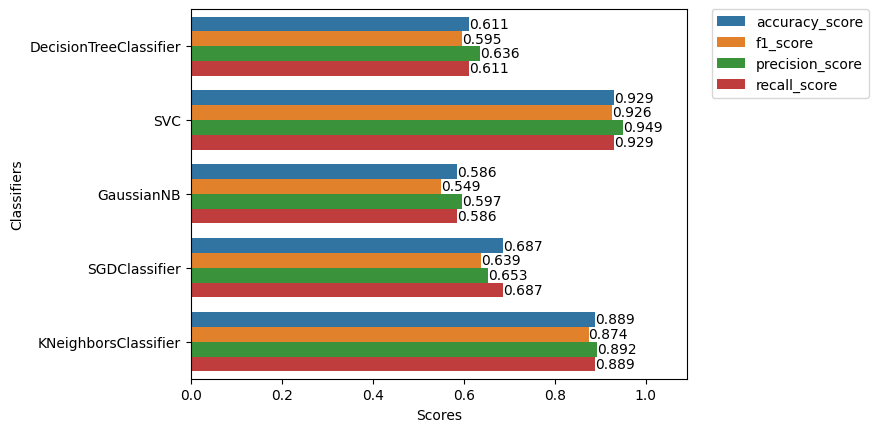

In [5]:
print('Fit the model without cross-validation or hyperparameter tuning. \n')

metrics_list = []

for classifier in classifiers:
    classifier.fit(data.x_train, data.y_train)
    predictions = classifier.predict(data.x_test)

    classifier_metrics = Metrics(classifier_name=classifier.__class__.__name__)
    # Computing metrics
    classifier_metrics.add_metric('accuracy_score', accuracy_score(data.y_test, predictions))
    classifier_metrics.add_metric('f1_score', f1_score(data.y_test, predictions, average='macro'))
    classifier_metrics.add_metric('precision_score', precision_score(data.y_test, predictions, average='macro'))
    classifier_metrics.add_metric('recall_score', recall_score(data.y_test, predictions, average='macro'))

    metrics_list.append(classifier_metrics)

Metrics.show_metrics_list(metrics_list)

#### _With cross-validation_
We then train the models on the training set with cross-validation.

The number of folds is chosen to be the number of samples in the least represented class to ensure that each fold contains at least one sample of each class. (This is automatically done by `sklearn.model_selection.StratifiedKFold` used by the function `cross_validate`.)

Fit the model with cross-validation.



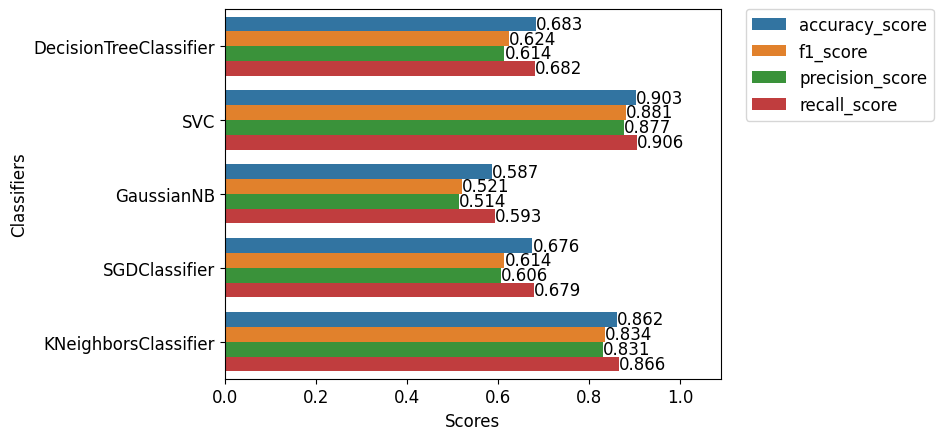

In [6]:
print('Fit the model with cross-validation.\n')

metrics_list_cv = []

for classifier in classifiers:
    scores = cross_validate(classifier, data.x_tab, data.y_tab, cv=least_populated_class_count, n_jobs=-1, return_train_score=True, scoring=['accuracy', 'precision_macro', 'recall_macro', 'f1_macro'])

    classifier_metrics = Metrics(classifier_name=classifier.__class__.__name__)
    # Storing metrics
    classifier_metrics.add_metric('accuracy_score', scores['test_accuracy'].mean())
    classifier_metrics.add_metric('f1_score', scores['test_f1_macro'].mean())
    classifier_metrics.add_metric('precision_score', scores['test_precision_macro'].mean())
    classifier_metrics.add_metric('recall_score', scores['test_recall_macro'].mean())

    metrics_list_cv.append(classifier_metrics)

Metrics.show_metrics_list(metrics_list_cv)


#### _With cross-validation and hyperparameter tuning_
We then train the models on the training set with cross-validation and using the best hyperparameters found using the dedicated notebook.

Fit the model with cross-validation and the best hyperparameters.



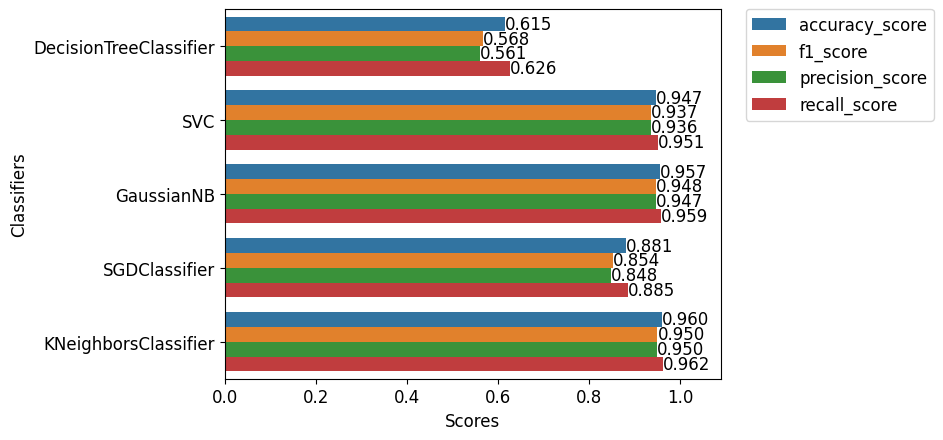

In [7]:
param_grids = []

selected_classifiers = [classifier.__class__.__name__ for classifier in classifiers]

for i, clf_name in enumerate(selected_classifiers):
    if clf_name == 'DecisionTreeClassifier':
        classifiers[i].set_params(**{
            'criterion': 'gini',
            'max_depth': None,
            'max_features': 'sqrt',
            'min_samples_leaf': 1,
            'min_samples_split': 5,
            'splitter': 'best',
            })
        
    if clf_name == 'RandomForestClassifier':
        classifiers[i].set_params(**{
            'criterion': 'gini',
            'max_features': 'log2',
            'min_samples_split': 2,
            'n_estimators': 500,
            })

    if clf_name == 'BaggingClassifier':
        classifiers[i].set_params(**{
            'bootstrap': False,
            'bootstrap_features': True,
            'max_features': 0.1,
            'max_samples': 0.5,
            'n_estimators': 100,
            })

    if clf_name == 'LogisticRegression':
        classifiers[i].set_params(**{
            'C': 1000,
            'max_iter': 100,
            'penalty': 'l2',
            'solver': 'liblinear',
            })

    if clf_name == 'SVC':
        classifiers[i].set_params(**{
            'C': 50,
            'gamma': 'scale',
            'kernel': 'linear',
            })

    if clf_name == 'GaussianNB':
        classifiers[i].set_params(**{
            'var_smoothing': 0.005,
            })

    if clf_name == 'SGDClassifier':
        classifiers[i].set_params(**{
            'alpha': 0.0001,
            'loss': 'modified_huber',
            'max_iter': 2000,
            'penalty': 'l1',
            })

    if clf_name == 'KNeighborsClassifier':
        classifiers[i].set_params(**{
            'algorithm': 'auto',
            'leaf_size': 1,
            'n_neighbors': 1,
            'p': 1,
            'weights': 'distance',
            })

    if clf_name == 'GradientBoostingClassifier':
        classifiers[i].set_params(**{
            'criterion': 'friedman_mse',
            'learning_rate': 0.025,
            'max_depth': 2,
            'max_features': 'log2',
            'min_samples_split': 10,
            'n_estimators': 500,
            })

    if clf_name == 'MLPClassifier':
        classifiers[i].set_params(**{
            'activation': 'logistic',
            'alpha': 0.01,
            'hidden_layer_sizes': (100,),
            'learning_rate': 'adaptive',
            'max_iter': 500,
            'solver': 'lbfgs',
            })

    if clf_name == 'AdaBoostClassifier':
        classifiers[i].set_params(**{
            'algorithm': 'SAMME.R',
            'learning_rate': 0.01,
            'n_estimators': 500,
            })

print('Fit the model with cross-validation and the best hyperparameters.\n')

metrics_list_cv = []

for classifier in classifiers:
    scores = cross_validate(classifier, data.x_tab, data.y_tab, cv=least_populated_class_count, n_jobs=-1, return_train_score=True, scoring=['accuracy', 'precision_macro', 'recall_macro', 'f1_macro'])

    classifier_metrics = Metrics(classifier_name=classifier.__class__.__name__)
    # Storing metrics
    classifier_metrics.add_metric('accuracy_score', scores['test_accuracy'].mean())
    classifier_metrics.add_metric('f1_score', scores['test_f1_macro'].mean())
    classifier_metrics.add_metric('precision_score', scores['test_precision_macro'].mean())
    classifier_metrics.add_metric('recall_score', scores['test_recall_macro'].mean())

    metrics_list_cv.append(classifier_metrics)

Metrics.show_metrics_list(metrics_list_cv)

#### _Plotting metrics for each fold_
We plot the metrics for each fold to see if there is a significant difference between the folds.

The printed values are the mean for each metric over all folds.

Classifier : DecisionTreeClassifier
	Mean train accuracy : 0.9499277125603671
	Mean test accuracy : 0.6565040650406504
	Mean train precision : 0.9575597732794703
	Mean test precision : 0.5921717171717171
	Mean train recall : 0.9497053872053872
	Mean test recall : 0.6647727272727273
	Mean train f1 : 0.9498495046643912
	Mean test f1 : 0.6046777296777297


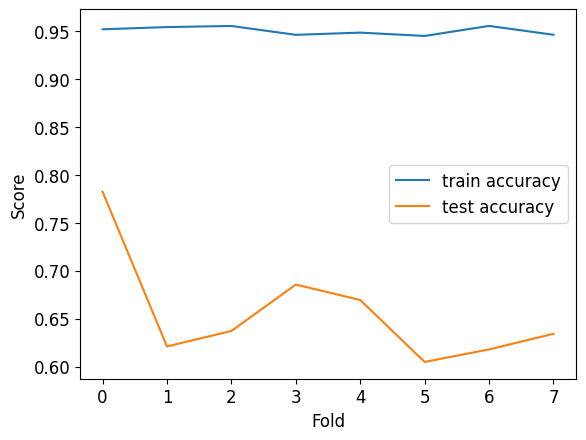



Classifier : SVC
	Mean train accuracy : 0.9992786239614715
	Mean test accuracy : 0.9474741017571466
	Mean train precision : 0.999354657687991
	Mean test precision : 0.936026936026936
	Mean train recall : 0.9992985409652076
	Mean test recall : 0.9513888888888888
	Mean train f1 : 0.9992885511461362
	Mean test f1 : 0.9371632996632997


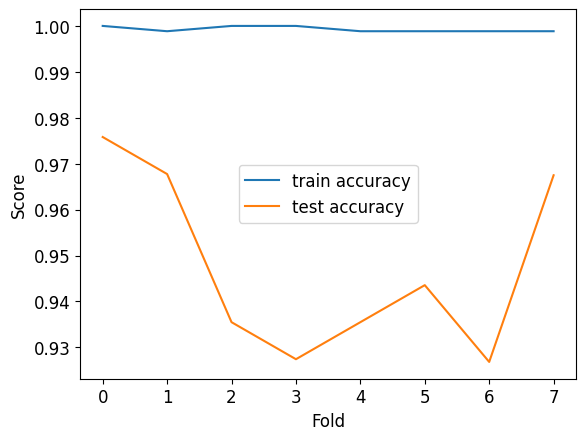



Classifier : GaussianNB
	Mean train accuracy : 0.9981240560345861
	Mean test accuracy : 0.9565548780487805
	Mean train precision : 0.9983024691358025
	Mean test precision : 0.9466540404040404
	Mean train recall : 0.9981411335578001
	Mean test recall : 0.9589646464646465
	Mean train f1 : 0.998119481710813
	Mean test f1 : 0.9476430976430977


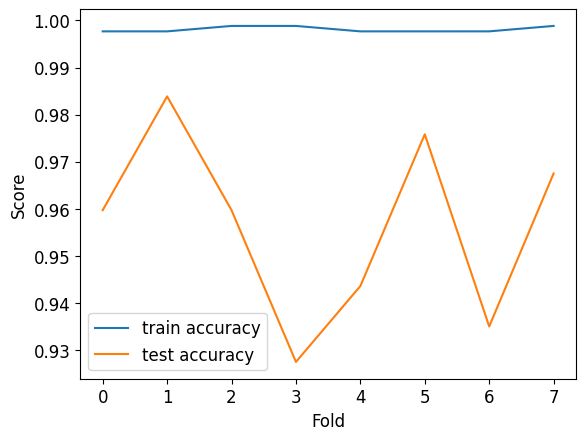



Classifier : SGDClassifier
	Mean train accuracy : 0.9767676293449047
	Mean test accuracy : 0.8898341201153946
	Mean train precision : 0.9804399199285563
	Mean test precision : 0.8609006734006734
	Mean train recall : 0.9768167789001123
	Mean test recall : 0.8933080808080809
	Mean train f1 : 0.9765731695680413
	Mean test f1 : 0.8654882154882155


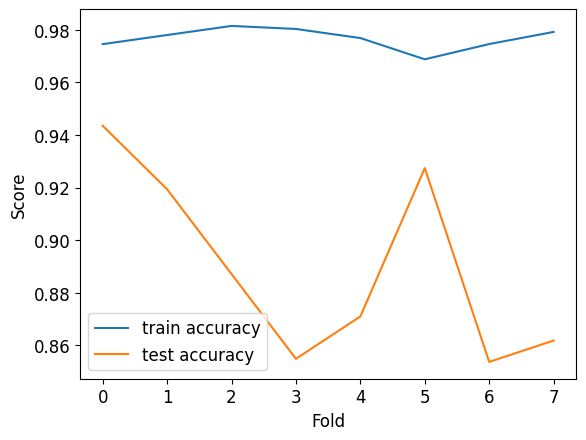



Classifier : KNeighborsClassifier
	Mean train accuracy : 1.0
	Mean test accuracy : 0.9595790715971675
	Mean train precision : 1.0
	Mean test precision : 0.9497053872053872
	Mean train recall : 1.0
	Mean test recall : 0.9621212121212122
	Mean train f1 : 1.0
	Mean test f1 : 0.9504629629629628


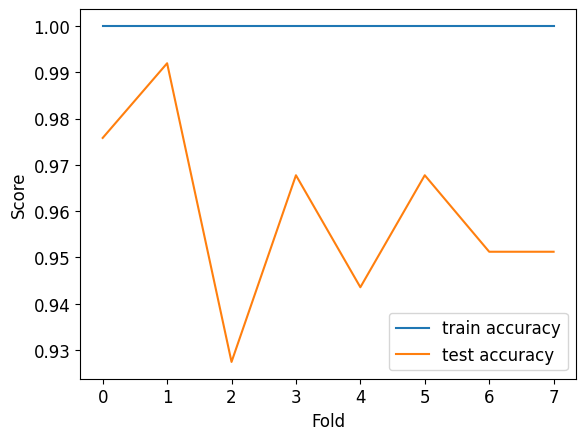

In [8]:
for classifier in classifiers:
    print(f'Classifier : {classifier.__class__.__name__}')

    scores = cross_validate(classifier, data.x_tab, data.y_tab, cv=least_populated_class_count, n_jobs=-1, return_train_score=True, scoring=['accuracy', 'precision_macro', 'recall_macro', 'f1_macro'])

    # Fitting one last time (needed ?)
    # classifier.fit(data.x_train, data.y_train)
    # print(Metrics(classifier, data))

    print(f'\tMean train accuracy : {scores["train_accuracy"].mean()}')
    print(f'\tMean test accuracy : {scores["test_accuracy"].mean()}')
    print(f'\tMean train precision : {scores["train_precision_macro"].mean()}')
    print(f'\tMean test precision : {scores["test_precision_macro"].mean()}')
    print(f'\tMean train recall : {scores["train_recall_macro"].mean()}')
    print(f'\tMean test recall : {scores["test_recall_macro"].mean()}')
    print(f'\tMean train f1 : {scores["train_f1_macro"].mean()}')
    print(f'\tMean test f1 : {scores["test_f1_macro"].mean()}')
    
    # Plotting the metrics for each fold
    plot_cross_validation: bool = True
    if plot_cross_validation:
        # Plot graph of scores
        plt.figure()
        plt.plot(scores['train_accuracy'], label='train accuracy')
        plt.plot(scores['test_accuracy'], label='test accuracy')
        # plt.plot(scores['train_precision_macro'], label='train precision')
        # plt.plot(scores['test_precision_macro'], label='test precision')
        # plt.plot(scores['train_recall_macro'], label='train recall')
        # plt.plot(scores['test_recall_macro'], label='test recall')
        # plt.plot(scores['train_f1_macro'], label='train f1')
        # plt.plot(scores['test_f1_macro'], label='test f1')
        plt.xlabel('Fold')
        plt.ylabel('Score')
        plt.legend()
        plt.show()
    
    print('\n')

#### _Plotting metrics for each size of training set_
To study the influence of the size of the training set on the performance of the models, we plot the accuracy for several sizes of training set.

Fit model with cross-validation for different training set sizes.

Classifier : DecisionTreeClassifier
	Mean train score : 0.8706829047358722
	Mean test score : 0.43195318646734854


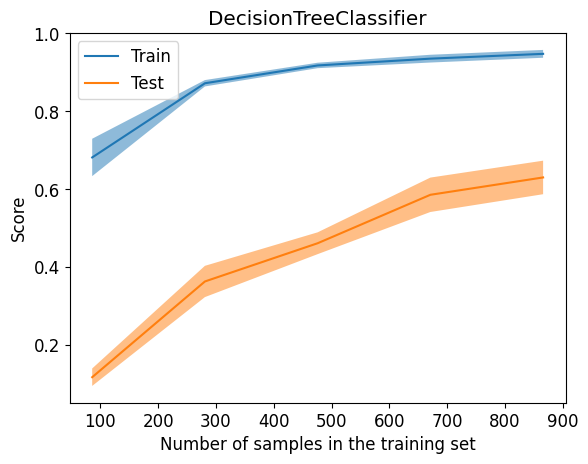

Classifier : SVC
	Mean train score : 0.9981306872190082
	Mean test score : 0.7917223970626802


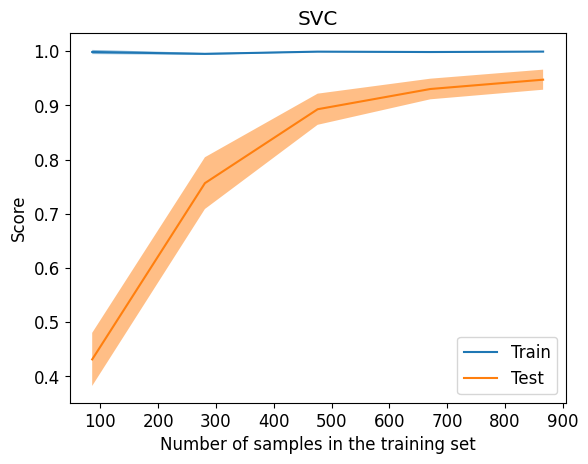

Classifier : GaussianNB
	Mean train score : 0.9994011643715389
	Mean test score : 0.7604215840545502


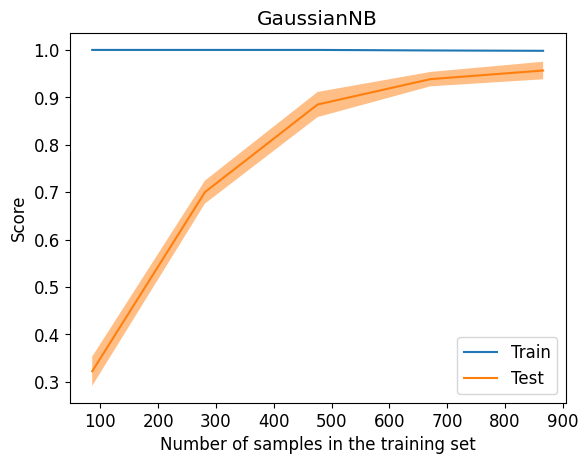

Classifier : SGDClassifier
	Mean train score : 0.9152975305356164
	Mean test score : 0.679145357985838


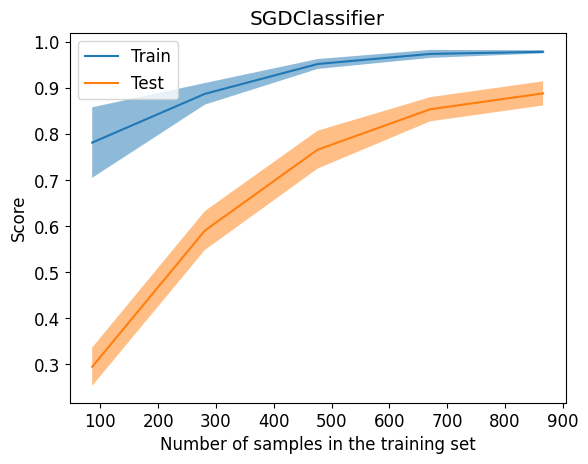

Classifier : KNeighborsClassifier
	Mean train score : 1.0
	Mean test score : 0.8343413978494624


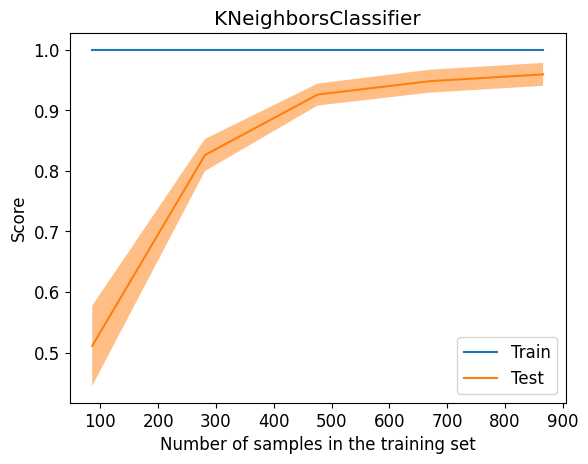

In [9]:
print('Fit model with cross-validation for different training set sizes.\n')

for classifier in classifiers:
    print(f'Classifier : {classifier.__class__.__name__}')
    # Determines cross-validated training and test scores for different training set sizes.
    # [doc](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.learning_curve.html#sklearn.model_selection.learning_curve)
    #   cv -> cv-fold cross-validation.
    #   n_jobs -> number of jobs to run in parallel : -1 means using all processors.
    #   No need to shuffle the data because it has already been shuffled (within Data class).
    train_sizes_abs, train_scores, test_scores = learning_curve(classifier, data.x_tab, data.y_tab, cv=least_populated_class_count, n_jobs=-1, )
    
    classifier.fit(data.x_train, data.y_train)
    print(f'\tMean train score : {train_scores.mean()}')
    print(f'\tMean test score : {test_scores.mean()}')
    
    plot_learning_curve: bool = True
    if plot_learning_curve:
        display = LearningCurveDisplay(train_sizes=train_sizes_abs, train_scores=train_scores, test_scores=test_scores, score_name="Score")
        display.plot()
        display.ax_.set_title(classifier.__class__.__name__)
        plt.show()
    
    # for train_size, cv_train_scores, cv_test_scores in zip(train_sizes_abs, train_scores, test_scores):
    #     print(f"{train_size} samples were used to train the model")
    #     print(f"The average train accuracy is {cv_train_scores.mean():.2f}")
    #     print(f"The average test accuracy is {cv_test_scores.mean():.2f}")